This example focuses on a simple implementation of a Graph Neural Network (GNN). Paper and their citation dataset is used for modelling.
The model predicts the subject of a paper given its words and citations network.

We first perform an EDA, then we build a couple of baseline models. Finally, we implement a graph convolutional network (GCN) to predict paper subject.

In [1]:
!pip install -q tensorflow-gnn 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.2/559.2 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.5/544.5 KB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.2/526.2 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.4 MB/s eta 0:00:00

In [2]:
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [3]:
!pip install 'networkx<2.7' #NOTE networkx might have dependency issues with scipy; thus reinstall is advised.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [4]:
#Import libraries
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

import tensorflow as tf
import tensorflow_gnn as tfgnn

from sklearn.metrics import classification_report,confusion_matrix

In [5]:
#Define a helper function

def classification_summary(y_test,y_pred,labels=None):
  """
  Function takes test labels and predicted labels to return a classification report and a confusion matrix heatmap

  #Args:
    y_test, array(int/float)-test labels
    y_pred, array(int/float)-predicted labels
    labels, array/list(str)- names for different predicted classes
  #Returns:
    classification report and a confusion matrix heatmap
  """

  print(classification_report(y_test,y_pred))

  sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.show()

  return

In [6]:
#Import data

file=tf.keras.utils.get_file(fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True)

path=os.path.join(os.path.dirname(file),'cora')

#Check data
! ls -al {path}

168052/168052 [==============================] - 0s 3us/step
total 7728
drwxr-sr-x 2 6155 1108    4096 Feb 18  2007 .
drwxr-xr-x 3 root root    4096 Mar  1 15:52 ..
-rwxr-xr-x 1 6155 1108   69928 Feb 18  2007 cora.cites
-rwxr-xr-x 1 6155 1108 7823427 Feb 18  2007 cora.content
-rwxr-xr-x 1 6155 1108    1560 Feb 18  2007 README


In [7]:
#Process data
citations=pd.read_csv(os.path.join(path, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"])

columns=["ID"]+[f"term_{i}" for i in range(1433)]+["subject"]
papers=pd.read_csv(os.path.join(path, "cora.content"),
    sep="\t",
    header=None,
    names=columns)

#Source column describes paper IDS and the target column describes a cited paper ID
print(citations.shape)
print(citations.head())
print(citations.sample(frac=1).head())

print(papers.shape)
print(papers.head())


(5429, 2)
   target   source
0      35     1033
1      35   103482
2      35   103515
3      35  1050679
4      35  1103960
      target   source
2385   22883    22876
3847   90470  1129994
4565  213246    34263
902     3231     8821
3986  107569  1107385
(2708, 1435)
        ID  term_0  term_1  term_2  term_3  term_4  term_5  term_6  term_7  \
0    31336       0       0       0       0       0       0       0       0   
1  1061127       0       0       0       0       0       0       0       0   
2  1106406       0       0       0       0       0       0       0       0   
3    13195       0       0       0       0       0       0       0       0   
4    37879       0       0       0       0       0       0       0       0   

   term_8  ...  term_1424  term_1425  term_1426  term_1427  term_1428  \
0       0  ...          0          0          1          0          0   
1       0  ...          0          1          0          0          0   
2       0  ...          0          0       

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


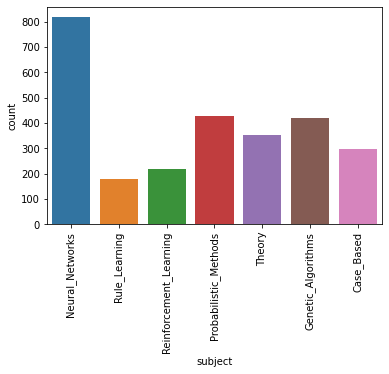

In [8]:
#Explore data

print(papers.subject.value_counts())

sns.countplot(x=papers.subject)
plt.xticks(rotation=90)
plt.show()

In [9]:
#Convert IDs to indexes

class_idxs={name:id for id,name in enumerate(sorted(papers['subject'].unique()))}
paper_idxs={name:id for id,name in enumerate(sorted(papers['ID'].unique()))}


citations['target']=citations['target'].apply(lambda name: paper_idxs[name])
citations['source']=citations['source'].apply(lambda name: paper_idxs[name])

papers['ID']=papers['ID'].apply(lambda name: paper_idxs[name])
papers['subject']=papers['subject'].apply(lambda name: class_idxs[name])

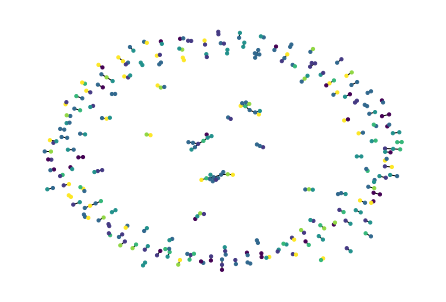

In [10]:
#Explore graph
#NOTE we are sampling a set of nodes to make the mapping more efficient

graph_sample=nx.from_pandas_edgelist(citations.sample(n=200))
graph_vals=list(papers[papers["ID"].isin(list(graph_sample.nodes))]['subject'])
nx.draw_spring(graph_sample,node_color=graph_vals,node_size=10)


In [11]:
papers.head()

,ID,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [12]:
#Split data

from sklearn.model_selection import train_test_split

#We need to preprocess data to extract classes and features
X=papers.iloc[:,:-1]
y=papers.iloc[:,-1]

feature_names=X.columns

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


X_train_baseline=X_train.iloc[:,1:].to_numpy()
y_train=y_train.to_numpy()
X_test_baseline=X_test.iloc[:,1:].to_numpy()
y_test=y_test.to_numpy()

In [13]:
#Define parameters
BATCH=128
EPOCHS=250
INPUT=X_train_baseline.shape[1]
CLASS_NUM=len(y.unique())
hidden_units=[32,32,16]

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)

In [14]:
#Create a basline model
baseline_model=tf.keras.Sequential()

baseline_model.add(tf.keras.layers.Input(shape=(INPUT,)))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Dense(128,activation='gelu'))
baseline_model.add(tf.keras.layers.Dropout(0.2))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Dense(64,activation='gelu'))
baseline_model.add(tf.keras.layers.Dropout(0.2))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Dense(32,activation='gelu'))
baseline_model.add(tf.keras.layers.Dropout(0.2))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Dense(16,activation='gelu'))
baseline_model.add(tf.keras.layers.Dropout(0.2))

baseline_model.add(tf.keras.layers.Dense(CLASS_NUM,activation='softmax'))

baseline_model.summary()

baseline_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1433)             5732      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               183552    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [15]:
baseline_history=baseline_model.fit(X_train_baseline,y_train,epochs=EPOCHS, batch_size=BATCH,validation_split=0.1,callbacks=[es])

Epoch 1/250
16/16 [==============================] - 15s 78ms/step - loss: 2.1762 - accuracy: 0.1842 - val_loss: 1.9084 - val_accuracy: 0.3134
Epoch 2/250
16/16 [==============================] - 0s 22ms/step - loss: 1.8169 - accuracy: 0.2832 - val_loss: 1.8718 - val_accuracy: 0.3272
Epoch 3/250
16/16 [==============================] - 0s 21ms/step - loss: 1.6232 - accuracy: 0.3822 - val_loss: 1.8212 - val_accuracy: 0.3226
Epoch 4/250
16/16 [==============================] - 0s 18ms/step - loss: 1.4561 - accuracy: 0.4592 - val_loss: 1.7523 - val_accuracy: 0.3364
Epoch 5/250
16/16 [==============================] - 0s 23ms/step - loss: 1.2985 - accuracy: 0.5305 - val_loss: 1.6685 - val_accuracy: 0.3548
Epoch 6/250
16/16 [==============================] - 0s 21ms/step - loss: 1.1522 - accuracy: 0.6003 - val_loss: 1.5732 - val_accuracy: 0.4009
Epoch 7/250
16/16 [==============================] - 0s 27ms/step - loss: 1.0255 - accuracy: 0.6583 - val_loss: 1.4674 - val_accuracy: 0.4332
Epoch

In [16]:
baseline_results=baseline_history.history
epoch=len(baseline_history.epoch)
baseline_results.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

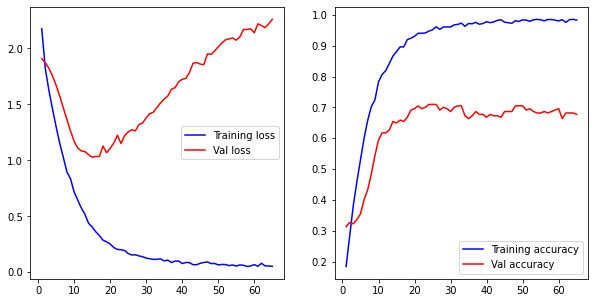

In [17]:
fig,ax=plt.subplots(1,2, figsize=(10,5))
ax.flatten()
ax[0].plot(np.arange(1,epoch+1),baseline_results['loss'],'b-',label='Training loss')
ax[0].plot(np.arange(1,epoch+1),baseline_results['val_loss'],'r-',label='Val loss')
ax[0].legend()
ax[1].plot(np.arange(1,epoch+1),baseline_results['accuracy'],'b-',label='Training accuracy')
ax[1].plot(np.arange(1,epoch+1),baseline_results['val_accuracy'],'r-',label='Val accuracy')
ax[1].legend()
plt.show()

In [18]:
#Evaluate baseline model

baseline_test_loss,baseline_test_acc=baseline_model.evaluate(X_test_baseline,y_test)
print(f"Baseline model test accuracy {baseline_test_acc} and loss {baseline_test_loss}")

17/17 [==============================] - 0s 3ms/step - loss: 1.0288 - accuracy: 0.6863
Baseline model test accuracy 0.6863468885421753 and loss 1.0287590026855469


17/17 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.52      0.64        63
           1       0.78      0.90      0.84        80
           2       0.59      0.91      0.72       152
           3       0.80      0.69      0.74        88
           4       0.85      0.52      0.64        54
           5       0.78      0.19      0.30        37
           6       0.56      0.47      0.51        68

    accuracy                           0.69       542
   macro avg       0.74      0.60      0.63       542
weighted avg       0.72      0.69      0.67       542



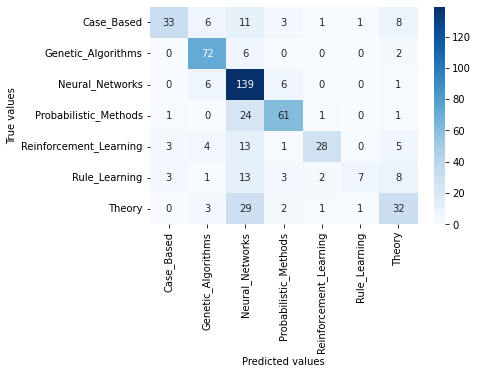

In [19]:
#Predict values
y_pred=baseline_model.predict(X_test_baseline)
y_pred_vals=np.argmax(y_pred,axis=1)
classification_summary(y_test,y_pred_vals,labels=class_idxs.keys())

In [20]:
#Create a baseline model to be more similar to GNN

#Include skipped nodes

def create_ffn(hidden_units, dropout_rate, name=None):
    #Implement Feedforward Network module
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(tf.keras.layers.BatchNormalization())
        fnn_layers.append(tf.keras.layers.Dense(units, activation=tf.nn.gelu))
        fnn_layers.append(tf.keras.layers.Dropout(dropout_rate))
        
    return tf.keras.Sequential(fnn_layers, name=name)

    

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):

    inputs = tf.keras.layers.Input(shape=(INPUT,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)

    for block_idx in range(1,5):
        # Create an FFN block
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 1}")(x)
        # Add skip connection
        x = tf.keras.layers.Add(name=f"skip_connection{block_idx + 1}")([x, x1])

    # Get model probabilities
    output = tf.keras.layers.Dense(num_classes, activation='softmax',name="prob")(x)
    # Create the model
    return tf.keras.Model(inputs=inputs, outputs=output, name="baseline")

In [21]:
baseline_model2=create_baseline_model(hidden_units, CLASS_NUM, dropout_rate=0.25)
baseline_model2.summary()
baseline_model2.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 16)           53460       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 16)           2448        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 16)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [22]:
baseline_history2=baseline_model2.fit(X_train_baseline,y_train,epochs=EPOCHS, batch_size=BATCH,validation_split=0.1,callbacks=[es])

Epoch 1/250
16/16 [==============================] - 16s 66ms/step - loss: 4.8516 - accuracy: 0.0934 - val_loss: 1.9241 - val_accuracy: 0.2581
Epoch 2/250
16/16 [==============================] - 0s 23ms/step - loss: 3.7307 - accuracy: 0.1016 - val_loss: 1.9144 - val_accuracy: 0.2765
Epoch 3/250
16/16 [==============================] - 0s 23ms/step - loss: 3.0238 - accuracy: 0.1278 - val_loss: 1.9103 - val_accuracy: 0.2811
Epoch 4/250
16/16 [==============================] - 0s 23ms/step - loss: 2.7238 - accuracy: 0.1442 - val_loss: 1.9079 - val_accuracy: 0.2811
Epoch 5/250
16/16 [==============================] - 0s 24ms/step - loss: 2.4473 - accuracy: 0.1924 - val_loss: 1.9065 - val_accuracy: 0.2811
Epoch 6/250
16/16 [==============================] - 0s 23ms/step - loss: 2.2651 - accuracy: 0.2237 - val_loss: 1.9054 - val_accuracy: 0.2811
Epoch 7/250
16/16 [==============================] - 0s 23ms/step - loss: 2.1927 - accuracy: 0.2304 - val_loss: 1.9043 - val_accuracy: 0.2811
Epoch

In [23]:
baseline_results=baseline_history2.history
epoch=len(baseline_history2.epoch)
baseline_results.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

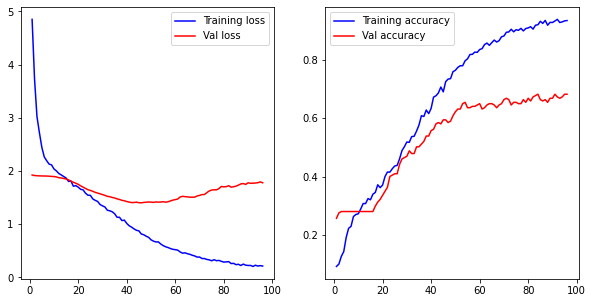

In [24]:
fig,ax=plt.subplots(1,2, figsize=(10,5))
ax.flatten()
ax[0].plot(np.arange(1,epoch+1),baseline_results['loss'],'b-',label='Training loss')
ax[0].plot(np.arange(1,epoch+1),baseline_results['val_loss'],'r-',label='Val loss')
ax[0].legend()
ax[1].plot(np.arange(1,epoch+1),baseline_results['accuracy'],'b-',label='Training accuracy')
ax[1].plot(np.arange(1,epoch+1),baseline_results['val_accuracy'],'r-',label='Val accuracy')
ax[1].legend()
plt.show()

In [25]:
#Evaluate baseline model

baseline_test_loss,baseline_test_acc=baseline_model2.evaluate(X_test_baseline,y_test)
print(f"Baseline model test accuracy {baseline_test_acc} and loss {baseline_test_loss}")

17/17 [==============================] - 0s 5ms/step - loss: 1.2789 - accuracy: 0.6144
Baseline model test accuracy 0.6143911480903625 and loss 1.2788691520690918


17/17 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.46      0.59        63
           1       0.52      0.75      0.62        80
           2       0.71      0.79      0.75       152
           3       0.57      0.64      0.60        88
           4       0.85      0.31      0.46        54
           5       0.93      0.35      0.51        37
           6       0.41      0.56      0.47        68

    accuracy                           0.61       542
   macro avg       0.69      0.55      0.57       542
weighted avg       0.67      0.61      0.61       542



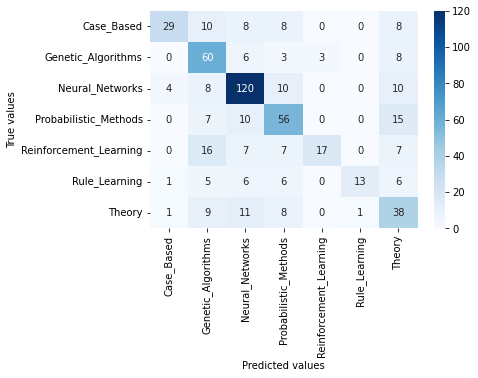

In [26]:
#Predict values
y_pred=baseline_model2.predict(X_test_baseline)
y_pred_vals=np.argmax(y_pred,axis=1)
classification_summary(y_test,y_pred_vals,labels=class_idxs.keys())

In [27]:
#Build GNN model

#This example demonstrates a simple approach to prepare graph data where you have
# a single graph that fits entirely in memory.


"""
The graph data is represented by the graph_info tuple:

    node_features, array[num_nodes, num_features] - an array that includes the node features. 
    The nodes are the papers, and the node_features are  binary 
    vectors for each paper.

    edges, array[num_edges, num_edges] -  a sparse adjacency matrix of the links between the nodes. 
    The links are the citations between the papers.

    edge_weights (optional), array[num_edges] - an array that includes the edge weights, 
    which quantify the relationships between nodes in the graph
"""


# Create an edges array (sparse adjacency matrix)  [2, num_edges]
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array [num_nodes, num_features]
node_features = tf.cast(papers.sort_values("ID")[feature_names].to_numpy(), dtype=tf.dtypes.float32)
# Create graph info tuple 
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)


Edges shape: (2, 5429)
Nodes shape: (2708, 1434)


###Implementing a graph convolution layer

We are going to use keras layers for our GCN. Key steps involve preparation to produce a message, then we aggregate neigbours features using edge weights and finally we update the node information.

### NOTE 
GRU requires sequence stacking while other aggregation types use concatenation.


In [28]:
class GraphConvLayer(tf.keras.layers.Layer):
    def __init__(self,hidden_units,
        dropout_rate=0.2, aggregation_type="mean",
        combination_type="concat",normalize=False,
        *args,**kwargs):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        #Prepare input
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)

        #Define update function
        if self.combination_type == "gated":

            self.update_fn = tf.keras.layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim]
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges]
        # neighbour_messages shape: [num_edges, representation_dim]
        # node_repesentations shape is [num_nodes, representation_dim]


        num_nodes = node_repesentations.shape[0]

        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes)
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):

        # node_repesentations shape is [num_nodes, representation_dim]
        # aggregated_messages shape is [num_nodes, representation_dim]


        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Process node embedings
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """
        GCN generates node embedings

        Inputs: a tuple of node_repesentations, edges, edge_weights

        Returns: node_embeddings of shape [num_nodes, representation_dim]
        """

        node_repesentations, edges, edge_weights = inputs

        # Get node_indices (source) and neighbour_indices (target)
        node_indices, neighbour_indices = edges[0], edges[1]

        # neighbour_repesentations shape is [num_edges, representation_dim]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)

        # Aggregate the neighbour messages
        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_repesentations)

        # Update the node embedding with the neighbour messages
        return self.update(node_repesentations, aggregated_messages)


### Implement GCN node classifier

The GNN classification model follows the Design Space for Graph Neural Networks approach.

###NOTE
Each additional convolutional layer captures information from a further level of neighbours. This can lead to oversmoothing if you add too many layers.


In [29]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights


        # Set edge_weights to ones if not provided
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        # Scale edge_weights to sum to 1
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")

        # Create the first GraphConv layer
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="GCN1")
        
        
        # Create the second GraphConv layer
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="GCN2")
        
        # Create a postprocess layer
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a prob layer
        self.compute_prob = tf.keras.layers.Dense(units=num_classes, activation='softmax')

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Add skip connection
        x = x1 + x
        # Apply the second graph conv layer
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Add skip connection
        x = x2 + x
        # Postprocess node embedding
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute probabilities for node embedings

        return self.compute_prob(node_embeddings)


In [35]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=CLASS_NUM,
    hidden_units=[32,32,16],
    dropout_rate=0.2,
    name="GCN_model")

print("GCN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()


GCN output shape: tf.Tensor(
[[0.14098431 0.14404644 0.14256401 0.14391491 0.14476548 0.14097025
  0.14275466]
 [0.15067822 0.1493308  0.13832107 0.14541897 0.13805752 0.13712269
  0.14107071]
 [0.20170474 0.16627187 0.12413982 0.13731392 0.12446828 0.11543201
  0.13066933]], shape=(3, 7), dtype=float32)
Model: "GCN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 16)                53496     
                                                                 
 GCN1 (GraphConvLayer)       multiple                  5472      
                                                                 
 GCN2 (GraphConvLayer)       multiple                  5472      
                                                                 
 postprocess (Sequential)    (2708, 16)                2448      
                                                                 
 dense_51 (Dens

In [36]:

gnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

history = gnn_model.fit(X_train.ID.to_numpy(), y_train,epochs=EPOCHS, batch_size=BATCH,validation_split=0.1,callbacks=[es])


Epoch 1/250
16/16 [==============================] - 33s 78ms/step - loss: 2.1756 - accuracy: 0.1329 - val_loss: 1.9505 - val_accuracy: 0.1106
Epoch 2/250
16/16 [==============================] - 0s 22ms/step - loss: 2.0989 - accuracy: 0.1334 - val_loss: 1.9467 - val_accuracy: 0.1521
Epoch 3/250
16/16 [==============================] - 0s 22ms/step - loss: 1.9959 - accuracy: 0.1709 - val_loss: 1.9405 - val_accuracy: 0.1659
Epoch 4/250
16/16 [==============================] - 0s 22ms/step - loss: 1.9456 - accuracy: 0.1919 - val_loss: 1.9305 - val_accuracy: 0.2811
Epoch 5/250
16/16 [==============================] - 0s 21ms/step - loss: 1.9251 - accuracy: 0.2258 - val_loss: 1.9151 - val_accuracy: 0.2811
Epoch 6/250
16/16 [==============================] - 0s 21ms/step - loss: 1.8956 - accuracy: 0.2360 - val_loss: 1.8999 - val_accuracy: 0.2811
Epoch 7/250
16/16 [==============================] - 0s 22ms/step - loss: 1.8523 - accuracy: 0.2673 - val_loss: 1.8828 - val_accuracy: 0.2811
Epoch

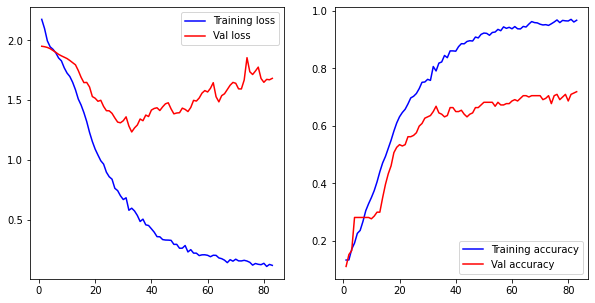

In [37]:
results=history.history
epoch=len(history.epoch)
results.keys()
fig,ax=plt.subplots(1,2, figsize=(10,5))
ax.flatten()
ax[0].plot(np.arange(1,epoch+1),results['loss'],'b-',label='Training loss')
ax[0].plot(np.arange(1,epoch+1),results['val_loss'],'r-',label='Val loss')
ax[0].legend()
ax[1].plot(np.arange(1,epoch+1),results['accuracy'],'b-',label='Training accuracy')
ax[1].plot(np.arange(1,epoch+1),results['val_accuracy'],'r-',label='Val accuracy')
ax[1].legend()
plt.show()

In [38]:
#Evaluate baseline model

test_loss,test_acc=gnn_model.evaluate(X_test.ID.to_numpy(),y_test)
print(f"Baseline model test accuracy {test_acc} and loss {test_loss}")

17/17 [==============================] - 0s 5ms/step - loss: 1.1339 - accuracy: 0.6624
Baseline model test accuracy 0.6623616218566895 and loss 1.1339373588562012


17/17 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.73      0.52      0.61        63
           1       0.78      0.91      0.84        80
           2       0.57      0.89      0.69       152
           3       0.82      0.72      0.76        88
           4       0.83      0.56      0.67        54
           5       0.90      0.24      0.38        37
           6       0.37      0.22      0.28        68

    accuracy                           0.66       542
   macro avg       0.71      0.58      0.61       542
weighted avg       0.68      0.66      0.64       542



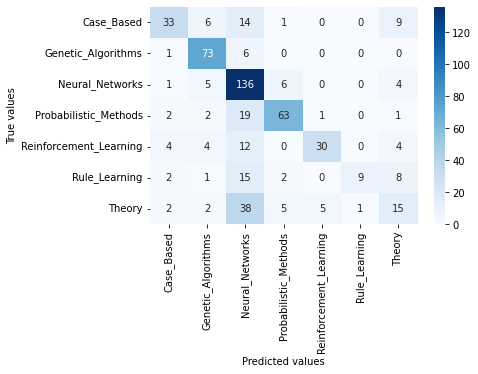

In [39]:
#Predict values
y_pred=gnn_model.predict(X_test.ID.to_numpy())
y_pred_vals=np.argmax(y_pred,axis=1)
classification_summary(y_test,y_pred_vals,labels=class_idxs.keys())